In [1]:
# Colab cell 1 — install libraries (run once)
!pip install pandas networkx matplotlib requests

In [2]:
# Colab cell — safer POST-based request to STRING
import requests
import pandas as pd

genes = ["BRCA1","BRCA2","TP53","PTEN","CHEK2","PALB2","ATM","RAD51","CDH1","NBN"]

url = "https://string-db.org/api/tsv/network"       # endpoint
params = {"species": 9606}                          # human = 9606
data = {"identifiers": "\n".join(genes)}            # newline-separated IDs in the request body

resp = requests.post(url, params=params, data=data, timeout=30)
resp.raise_for_status()   # raise an error if request failed

# save and inspect
with open("ppi_data.tsv", "w", encoding="utf-8") as f:
    f.write(resp.text)

df = pd.read_csv("ppi_data.tsv", sep="\t")
df.head()


,stringId_A,stringId_B,preferredName_A,preferredName_B,ncbiTaxonId,score,nscore,fscore,pscore,ascore,escore,dscore,tscore
0,9606.ENSP00000261584,9606.ENSP00000361021,PALB2,PTEN,9606,0.727,0.0,0.0,0,0.074,0.000,0.00,0.718
1,9606.ENSP00000261584,9606.ENSP00000269305,PALB2,TP53,9606,0.738,0.0,0.0,0,0.049,0.097,0.00,0.720
2,9606.ENSP00000261584,9606.ENSP00000265433,PALB2,NBN,9606,0.801,0.0,0.0,0,0.095,0.000,0.50,0.596
3,9606.ENSP00000261584,9606.ENSP00000372023,PALB2,CHEK2,9606,0.921,0.0,0.0,0,0.068,0.000,0.00,0.919
4,9606.ENSP00000261584,9606.ENSP00000278616,PALB2,ATM,9606,0.945,0.0,0.0,0,0.000,0.000,0.54,0.886


In [4]:
print(resp.status_code)        # should be 200
print(len(resp.text))          # should be > 0 if results returned
print(resp.text[:500])         # preview first 500 characters


200
3669
stringId_A	stringId_B	preferredName_A	preferredName_B	ncbiTaxonId	score	nscore	fscore	pscore	ascore	escore	dscore	tscore
9606.ENSP00000261584	9606.ENSP00000361021	PALB2	PTEN	9606	0.727	0	0	0	0.074	0	0	0.718
9606.ENSP00000261584	9606.ENSP00000269305	PALB2	TP53	9606	0.738	0	0	0	0.049	0.097	0	0.72
9606.ENSP00000261584	9606.ENSP00000265433	PALB2	NBN	9606	0.801	0	0	0	0.095	0	0.5	0.596
9606.ENSP00000261584	9606.ENSP00000372023	PALB2	CHEK2	9606	0.921	0	0	0	0.068	0	0	0.919
9606.ENSP00000261584	9606.ENSP


Nodes: 10 Edges: 40


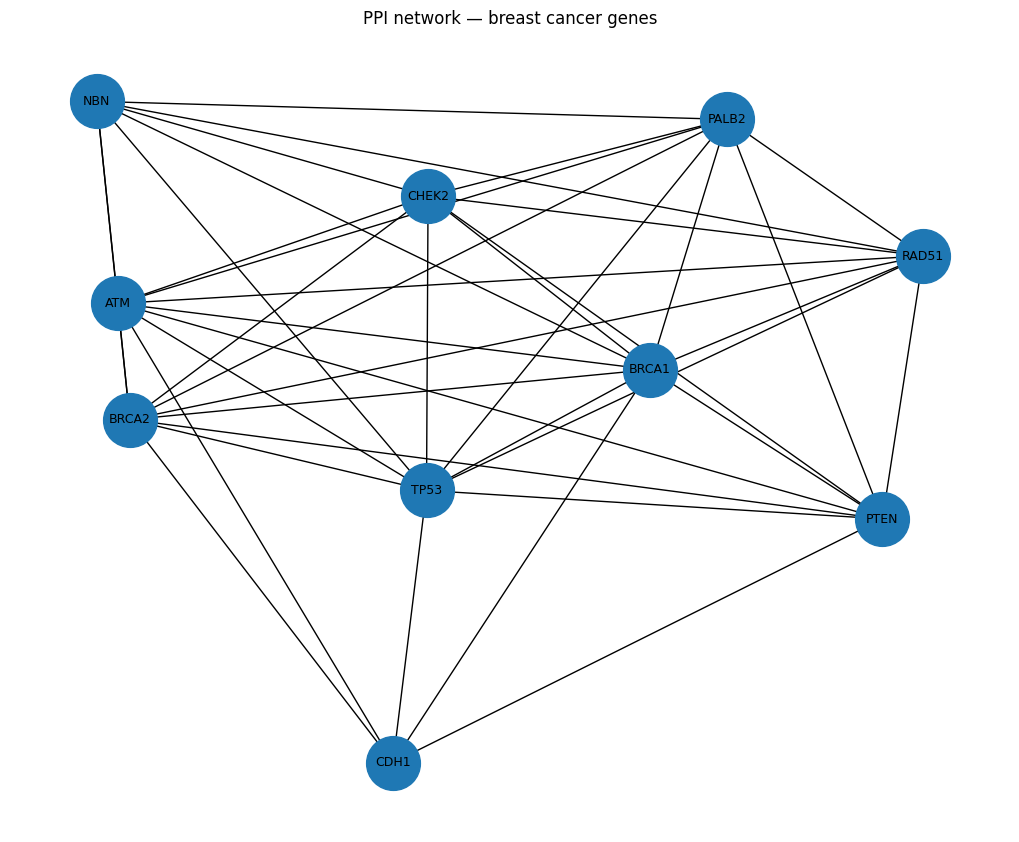

In [5]:
# Colab cell 3 — build network and draw
import networkx as nx
import matplotlib.pyplot as plt

# Read data (if not already in df)
df = pd.read_csv("ppi_data.tsv", sep="\t")

# Build graph (use preferredName_A and preferredName_B from STRING)
G = nx.Graph()
for _, row in df.iterrows():
    a = row['preferredName_A']
    b = row['preferredName_B']
    score = row.get('score', 0)  # STRING score (higher = stronger)
    G.add_edge(a, b, weight=score)

print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

# Simple plot
plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, seed=42)   # positions for nodes
nx.draw(G, pos, with_labels=True, node_size=1500, font_size=9)
plt.title("PPI network — breast cancer genes")
plt.show()

In [6]:
# Colab cell 4 — calculate degree centrality (hubs)
deg = dict(G.degree())
deg_sorted = sorted(deg.items(), key=lambda x: x[1], reverse=True)
print("Top hubs (node : degree):")
for node, d in deg_sorted[:10]:
    print(node, ":", d)

Top hubs (node : degree):
TP53 : 9
ATM : 9
BRCA1 : 9
BRCA2 : 9
PALB2 : 8
PTEN : 8
CHEK2 : 8
RAD51 : 8
NBN : 7
CDH1 : 5


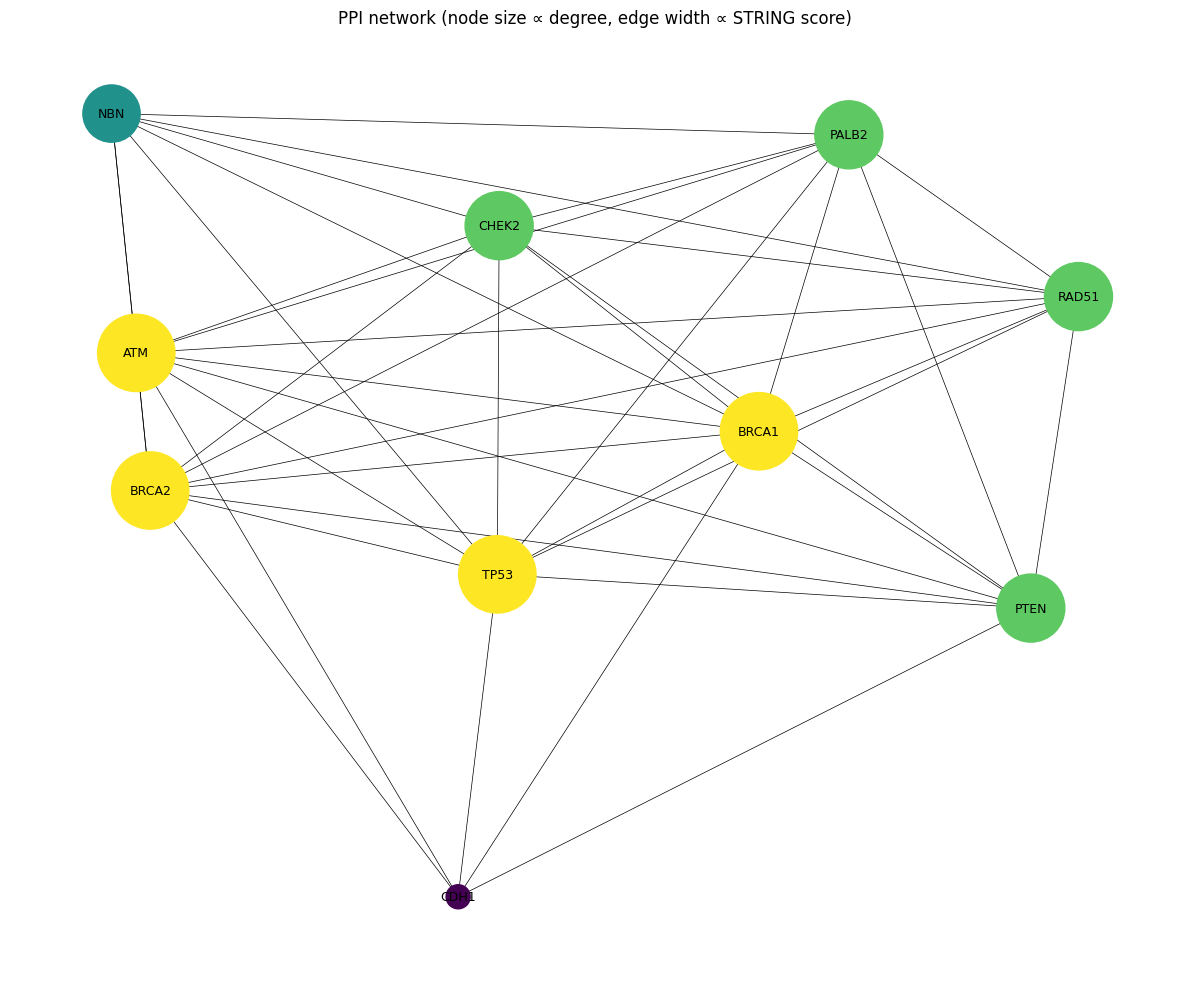

In [7]:
# Colab cell 5 — nicer plot with node sizes and edge widths
import numpy as np

degree_values = np.array([deg[n] for n in G.nodes()])
node_sizes = 300 + (degree_values - degree_values.min()) * 700  # scale sizes

# Edge width based on STRING score (if available)
edge_widths = [ (d.get('weight',0) / 500.0) + 0.5 for _,_,d in G.edges(data=True) ]

plt.figure(figsize=(12,10))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_sizes, cmap=plt.cm.viridis)
nx.draw_networkx_edges(G, pos, width=edge_widths)
nx.draw_networkx_labels(G, pos, font_size=9)
plt.title("PPI network (node size ∝ degree, edge width ∝ STRING score)")
plt.axis('off')
plt.tight_layout()
plt.savefig("ppi_network.png", dpi=200)
plt.show()